<a href="https://colab.research.google.com/github/mc365691/2023_CISC7201-courseproject_mc36569/blob/main/Lecture_2_notebook_student_New_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Practice: Linear Regression

For lecture 2, you have two parts of hands-on practice.
- Part 1. You will explore the two key methods of solving linear regression.
- Part 2. You will see the difference between the training and test errors.

## Part 1. Solving linear regression

### Select the dataset
We have two datasets:
- Dataset 1: A synthetic dataset where we generate linearly correlated y and X with artificially added noise
- Dataset 2: Student height/weight dataset used in the first lecture

### Tasks:
- Task 1: Implement the close-form solution for simple linear regression. If your code is correct, the code will print Intercept (w0) and coeff (w1) same as those from sklearn
- Task 2: Using dataset 1, implement a gradient descent algorithm for simple linear regression. If your code is correct, the code will print Intercept (w0) and coeff (w1) close to the closed-form solution (you can play with learning_rate and max_iteration to get even closer results)
- Task 3: After successfully completing task 1 and 2, switch to dataset 2 and try to compare the results from closed-form method and gradient descent.
    - Hint: If something goes wrong, check the plot. You may want to change the learning rate or number of iterations.


In [3]:
# load necessary libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

print(np.__version__)
print(matplotlib.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)



1.23.5
3.7.1
1.5.3
1.2.2
0.14.1


In [4]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
data = pd.read_csv("/content/gdrive/My Drive/student_dataset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Select dataset
# dataset 1: simulated dataset
X = 10 * np.random.rand(50,1)
y = -2 +  10*X + 0.5*np.random.randn(50,1)


# dataset 2: your height and weight dataset
# df  = pd.read_csv("student_dataset.csv")
# X=np.expand_dims(df["Height"].to_numpy(), axis=1)
# y=np.expand_dims(df["Weight"].to_numpy(), axis=1)


## Exercise 1: Completing Closed form solution below.

Verfied our implementation againt that from sklearn

Closed-form solution from sklearn: 
Intercept: [-2.01778319], coeff: [[10.00476254]]
Closed-form solution: 
Intercept: [-2.01778319], coeff: [10.00476254]


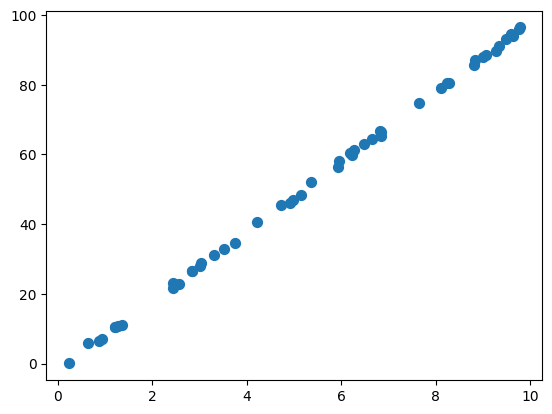

In [8]:
# Closed-form solution
# read the data
plt.scatter(X, y, s=50)

print('Closed-form solution from sklearn: ')
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X, y)
print(f'Intercept: {lr_model.intercept_}, coeff: {lr_model.coef_}')



# add constant for intercept computation (add an all-one vector in the first column)
X_ = sm.add_constant(X)
print('Closed-form solution: ')
##########Your code here###########


params_closed_form = np.matmul(np.linalg.inv(np.matmul(X_.T, X_)), np.matmul(X_.T, y))
###################################
print(f'Intercept: {params_closed_form[0]}, coeff: {params_closed_form[1]}')


In [9]:
# preparation functions

def cost_function(w1,w0,X,y):
    y_pred = w1*X + w0
    cost_value = np.sum(np.square(y - y_pred))/len(X)
    return cost_value

def plot_gradient_descent_process(X, w1, w0, cost_history, w1_history, w0_history, angle):
    # Visualization
    fig = plt.figure(figsize = (16,5))

    # plot 1: fitted line
    plt.subplot(1, 3, 1)
    plt.scatter(X, y, s=50)
    # print(m_history)
    for i, (w1, w0) in enumerate(zip(w1_history,w0_history)):
        plt.plot(X, w1*X + w0, color = 'r', alpha=(i+1)/len(w1_history))
    plt.xlabel('X')
    plt.ylabel('y')

    # plot 2: cost over iteration
    plt.subplot(1, 3, 2)
    plt.plot(cost_history)
    plt.xlabel('#iteration')
    plt.ylabel('cost value')


    # plot 3: gradient descent process
    w1_range = np.max(w1_history)-np.min(w1_history)
    w0_range = np.max(w0_history)-np.min(w0_history)

    W1, W0  = np.meshgrid(np.linspace(w1_history[-1]-w1_range*2,w1_history[-1]+w1_range*2,100),
                          np.linspace(w0_history[-1]-w0_range,w0_history[-1]+w0_range,100)) # you can change the range of the plot in this line

    zs = np.array(  [cost_function(m, b, X, y)
                     for m, b in zip(np.ravel(W1), np.ravel(W0)) ] )
    Z = zs.reshape(W1.shape)
    anglesx = np.array(w1_history)[1:] - np.array(w1_history)[:-1]
    anglesy = np.array(w0_history)[1:] - np.array(w0_history)[:-1]

    #Surface plot
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_surface(W1, W0, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
    ax.plot(w1_history, w0_history, cost_history, marker = '*',markersize = 4, color = 'r', label = 'Gradient descent')
    #ax.plot(coefs[0],coefs[1], marker = '*', color = 'black', markersize = 10)
    ax.view_init(azim=angle)
    ax.set_xlabel('w1')
    ax.set_ylabel('w0')
    ax.set_zlabel('Cost function')
    ax.set_title('Gradient descent')
    ax.legend()


## Exercise 2: Completing the gradient descent algorithm in the code below

Intercept: 0.7171686445200897, coeff: 5.1060569488526735


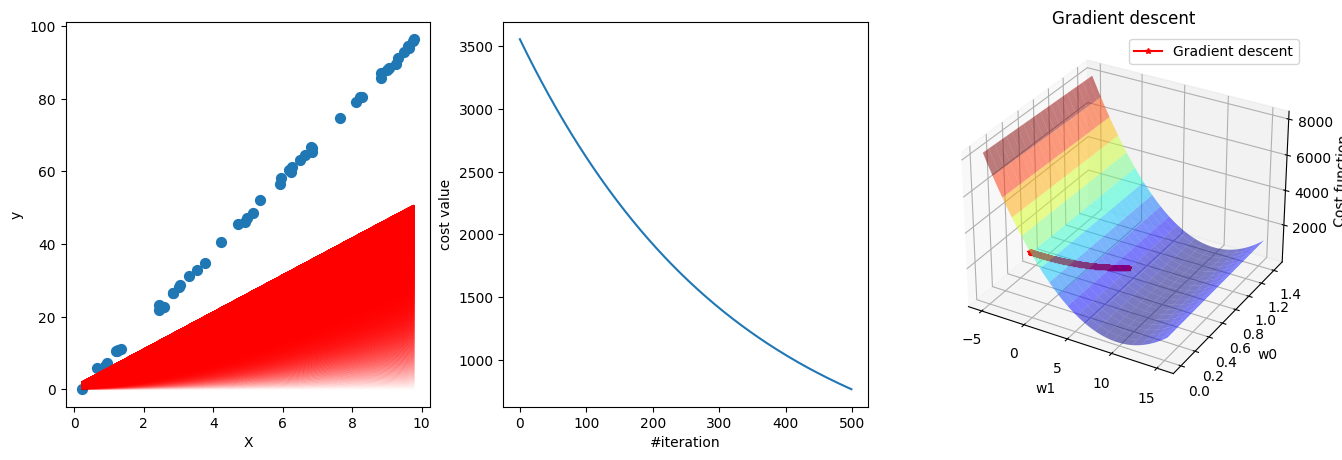

In [10]:
def fit_linear_regression(X, y, learning_rate, max_iters):
    w1 = 0 # initialize parameter w1
    w0 = 0 # initialize parameter w0
    n = len(X) # number of data instance
    cost_history = np.zeros(max_iters) # initialize historical cost for plotting
    w1_history = np.zeros(max_iters) # initialize w1 cost for plotting
    w0_history = np.zeros(max_iters) # initialize w0 cost for plotting

    for i in range(max_iters): #iterating for gradient updating
        y_pred = w1*X + w0 # compute predictions
        cost_value = np.sum(np.square(y - y_pred))/n # compute cost
        cost_history[i] = cost_value # record historical cost for plotting
        w1_history[i] = w1 # record historical w1 for plotting
        w0_history[i] = w0 # record historical w0 for plotting


        # please add the gradient descent updating below
        # 1. you need to compute the gradient of cost value w.r.t. w1 and w0
        # 2. update w1 and w0 according to the gradient, to minimize the cost
        #####################
        w0_gradient=-2*np.sum(y-y_pred)/n
        w1_gradient=-2*np.sum(X*(y-y_pred))/n

        w0=w0 - (learning_rate*w0_gradient)
        w1=w1-(learning_rate*w1_gradient)



        #####################

    return w1, w0, cost_history, w1_history, w0_history


# let's try it out!
learning_rate = 0.00002 # Learning rate, too small may lead to slow convergence, too large the gradient may explode and not converge
max_iteration = 500 # the number of iterations

w1, w0, cost_history, w1_history, w0_history = fit_linear_regression(X, y, learning_rate,max_iteration)
print(f'Intercept: {w0}, coeff: {w1}') #if correctly implemented

plot_gradient_descent_process(X, w1, w0, cost_history, w1_history, w0_history, -60)

### Exercise 3: Complete the following z-score standarization impmentation. You will explore the impact of feature scaling.


Intercept: 10.0047625245437, coeff: -2.017783186864321
29.701705234149514 51.67263121699417 10.0047625245437 -2.017783186864321


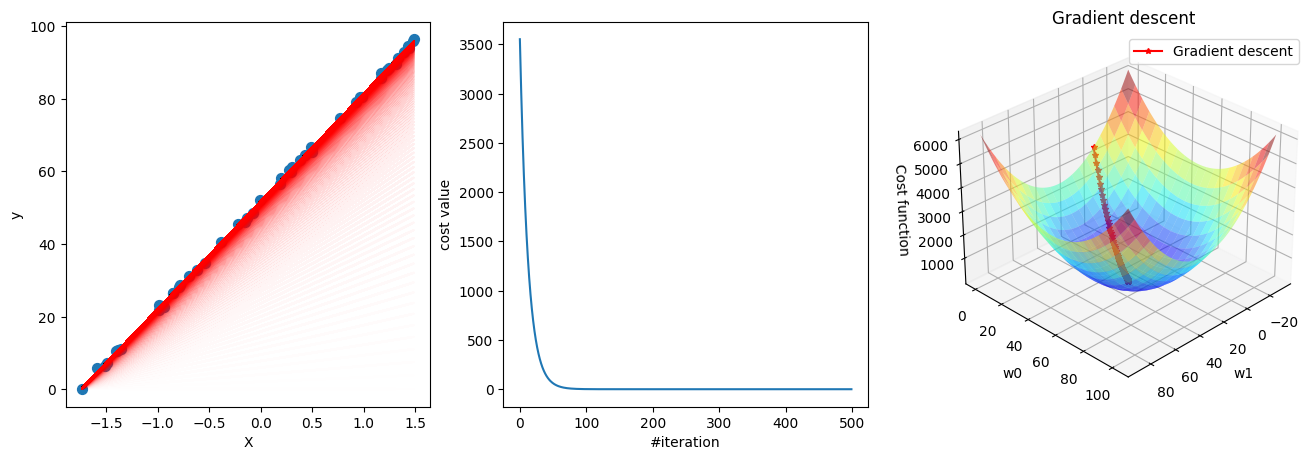

In [11]:
def feature_scaling(X):
    # z-score standarization
    #####################
    X_scaled = (X-np.mean(X))/np.std(X)

    #####################
    return X_scaled

def convert_params(w1, w0, w1_history, w0_history, X):
    # paramter reverse scaling
    w1_bak = w1/np.std(X)
    w0_bak = w0-w1*np.mean(X)/np.std(X)
    w1_history_bak = w1_history/np.std(X)
    w0_history_bak = w0_history-w1_history*np.mean(X)/np.std(X)
    return w1_bak, w0_bak, w1_history_bak, w0_history_bak

# let's try it out!
learning_rate = 0.02 # Learning rate, too small may lead to slow convergence, too large the gradient may explode and not converge
max_iteration = 500 # the number of iterations

w1, w0, cost_history, w1_history, w0_history = fit_linear_regression(feature_scaling(X), y, learning_rate,max_iteration)
w1_bak, w0_bak, w1_history_bak, w0_history_bak = convert_params(w1, w0, w1_history, w0_history, X)
print(f'Intercept: {w1_bak}, coeff: {w0_bak}')
print(w1, w0, w1_bak, w0_bak)

plot_gradient_descent_process(feature_scaling(X), w1, w0, cost_history, w1_history, w0_history,45)


## Part 2. Training/Test Error and Cross Validation


134.8519143027177 138.47751548847836
74.29782796395092 77.59470683942934
74.28558172432612 86.5666281417185
74.20683685490482 79.67505257315413


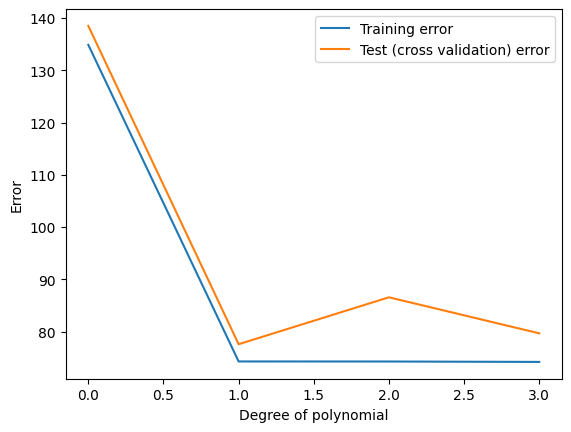

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# dataset 2: your height and weight dataset
df  = pd.read_csv("/content/gdrive/My Drive/student_dataset.csv")
X=np.expand_dims(df["Height"].to_numpy(), axis=1)
y=np.expand_dims(df["Weight"].to_numpy(), axis=1)

# training error v.s. test error
folds = KFold(n_splits = 5, shuffle = True) #k-fold cross validation
degrees = [0, 1, 2, 3 ] #polynomial degree
error_cv = np.zeros(len(degrees))
error_train = np.zeros(len(degrees))
for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=folds)
    error_cv[i] = np.mean(-scores)
    model.fit(X, y)
    error_train[i] = mean_squared_error(model.predict(X),y)
    print(error_train[i], error_cv[i])

plt.plot(degrees, error_train, label = 'Training error')
plt.plot(degrees, error_cv, label = 'Test (cross validation) error')
plt.xlabel('Degree of polynomial')
plt.ylabel('Error')
plt.legend()

